# Introduction to Big Data Analytics - List 5
### _Wojciech Korczyński, 229949_


In [1]:
# importing libraries
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, ChiSqSelector
from pyspark.ml import Pipeline
import pyspark.sql.functions as f
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,\
    RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from sklearn.metrics import classification_report, confusion_matrix

C:\Users\wojte\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Creating the Spark Session
spark = SparkSession.builder.appName("ML_bank_marketing").getOrCreate()

## Data loading

We load data from `.csv` file.

In [3]:
bankdata = spark.read.csv(path='bank.csv',
                         sep=',',
                         encoding='UTF-8',
                         comment=None,
                         header=True,
                         inferSchema=True)

In [4]:
bankdata.show(n=5, truncate=False)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1       |-1   |0       |unknown |yes    |
|56 |admin.    |married|secondary|no     |45     |no     |no  |unknown|5  |may  |1467    |1       |-1   |0       |unknown |yes    |
|41 |technician|married|secondary|no     |1270   |yes    |no  |unknown|5  |may  |1389    |1       |-1   |0       |unknown |yes    |
|55 |services  |married|secondary|no     |2476   |yes    |no  |unknown|5  |may  |579     |1       |-1   |0       |unknown |yes    |
|54 |admin.    |married|tertiary |no     |184    |no     |no  |unknown|5  |m

In [5]:
pd.DataFrame(bankdata.take(5), columns=bankdata.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [6]:
bankdata.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



Category class is weel-balanced:

In [7]:
bankdata.groupBy("deposit").count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [8]:
bankdata.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|  count|             11162|  11162|   11162|    11162|  11162|             11162|  11162|11162|   11162|             11162|11162|             11162|             11162|             11162|             11162|   11162|  11162|
|   mean|41.231947679627304|   null|    null|     null|   null|1528.5385235620856|   null| null|    null

Lack of NULL values.

In [9]:
data_agg = bankdata.agg(*[f.count(f.when(f.isnull(col), col)).alias(col) for col in bankdata.columns])
data_agg.show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|      0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+



## Data preprocessing

It is neede to transform string data into numerical one using `StringIndexer` cause most of ML algorithms expect nummercial values. In order to avoid some hierarchy, indexed data have to be transforemd using `OneHotEncoderEstimator` which creates sparse vector. All features will be written in one vecotr column using `VectorAssembler`.

As features we do not take _duration_ which too affects the depoit attribute - if customer takes a deposity it is obciour that a phone call lasts longer. We also do not take a date realted attributes (*day*, *month*) .

In [10]:
category_columns = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'poutcome']
indexers = [
    StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col))
    for col in category_columns
]

In [11]:
label_string_indexer = StringIndexer(inputCol = 'deposit', outputCol = 'label')

In [12]:
encoders = OneHotEncoderEstimator(dropLast=False)\
    .setInputCols([indexer.getOutputCol() for indexer in indexers])\
    .setOutputCols(["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers])    

In [13]:
numericCols = ['age', 'balance', 'campaign', 'pdays', 'previous']
assembler_inputs = [out_col for out_col in encoders.getOutputCols()] + numericCols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

We create a `Pipeline` which performs all action needed to preprocess data.

In [14]:
stages = [indexer for indexer in indexers]
stages += [label_string_indexer]
stages += [encoders]
stages += [assembler]
pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(bankdata)
bankdata_updated = pipelineModel.transform(bankdata)

In [15]:
original_cols = bankdata.columns
selected_cols = ['label', 'features'] + original_cols
df = bankdata_updated.select(selected_cols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [16]:
df.show(n=5, truncate=False)

+-----+------------------------------------------------------------------------------------------------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|label|features                                                                                        |age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+-----+------------------------------------------------------------------------------------------------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|1.0  |(37,[3,12,15,19,22,23,26,28,32,33,34,35],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0,2343.0,1.0,-1.0])|59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1       |-1   |0       |unknown |yes    |
|1.0  |(37,[3,12,15,19,21,23,26,28,32,33,34,35],[1.0,1.0,1.0

We see that deposit YES value is labelled as 1.0. Thus NO value is labelled as 0.0.

In [17]:
df.groupBy("label", 'deposit').count().show()

+-----+-------+-----+
|label|deposit|count|
+-----+-------+-----+
|  0.0|     no| 5873|
|  1.0|    yes| 5289|
+-----+-------+-----+



## Selecting features

We select features performing $\chi^2$ test for independence between the features and the label column.

In [99]:
features_num = 29
selector = ChiSqSelector()\
    .setNumTopFeatures(features_num)\
    .setFeaturesCol("features")\
    .setLabelCol("label")\
    .setOutputCol("selected_features")

bankdata_with_sel_feat = selector.fit(bankdata_updated).transform(bankdata_updated)

In [100]:
selected_cols = ['label', 'features', 'selected_features'] + original_cols
df = bankdata_with_sel_feat.select(selected_cols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- selected_features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [101]:
df.show(n=5, truncate=False)

+-----+------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|label|features                                                                                        |selected_features                                                                              |age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+-----+------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|1.0  |

## Splitting the dataset

We split our dataset into training and test datesets.

In [102]:
train, test = bankdata_with_sel_feat.randomSplit([0.80, 0.20], seed = 42)
print("Train dataset size: " + str(train.count()))
print("Test dataset size: " + str(test.count()))

Train dataset size: 8960
Test dataset size: 2202


Function calculating accuracy of given model:

In [49]:
def accuracy_m(predictions): 
    cm = predictions.select("label", "prediction")
    acc = cm.filter(cm.label == cm.prediction).count() / cm.count()
    print("Model accuracy: %.3f%%" % (acc * 100)) 
    return acc

best_accuracies = {}

In [50]:
def print_conf_matrix_and_report(predictions):
    y_true = predictions.select(['label']).collect()
    y_pred = predictions.select(['prediction']).collect()
    
    print(classification_report(y_true, y_pred))
    conf_mat = confusion_matrix(y_true, y_pred)  
    tick_labels=['no','yes']
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=tick_labels, yticklabels=tick_labels, cmap='Blues', cbar=None, annot_kws={"fontsize":20})
    plt.xticks(
        rotation=45,
        ha='right',
        fontsize=18
    )
    plt.yticks(fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.title("Confusion matrix", fontsize=26)

In [24]:
def print_best_accuracies():
    print("Best accuracies:")
    for model_name, acc in best_accuracies.items():
        print(" - " +model_name + ': ' + "%.3f%%" % (acc * 100))

## Logistic Regression

In [103]:
lr = LogisticRegression(featuresCol='selected_features',
                        labelCol='label',
                        maxIter=10,
                        regParam=0.3)
lr_model = lr.fit(train)


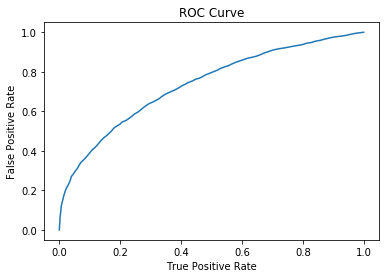

Training set areaUnderROC: 0.7355802541252234


In [104]:
roc = lr_model.summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(lr_model.summary.areaUnderROC))

In [105]:
lr_predictions = lr_model.transform(test)

In [106]:
lr_predictions.select('selected_features', 'rawPrediction', 'probability', 'prediction', 'label').show(10)

+--------------------+--------------------+--------------------+----------+-----+
|   selected_features|       rawPrediction|         probability|prediction|label|
+--------------------+--------------------+--------------------+----------+-----+
|(29,[4,9,12,13,15...|[-1.4237077096878...|[0.19408098964445...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[-0.4697727432987...|[0.38467003363244...|       1.0|  0.0|
|(29,[4,9,13,15,17...|[-0.5183696722551...|[0.37323353779774...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[-0.4760859406549...|[0.38317679832412...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[-0.4425740721414...|[0.39112779060023...|       1.0|  1.0|
|(29,[4,9,11,13,16...|[0.27121865803904...|[0.56739205924049...|       0.0|  0.0|
|(29,[4,9,12,13,15...|[-1.1967725424499...|[0.23204986077455...|       1.0|  1.0|
|(29,[4,9,12,13,15...|[-0.6039183325163...|[0.35344775353172...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[-1.2226982135817...|[0.22746196370378...|       1.0|  1.0|
|(29,[4,9,10,13,

In [107]:
accuracy_m(lr_predictions)

Model accuracy: 68.029%


0.6802906448683016

              precision    recall  f1-score   support

         0.0       0.67      0.76      0.71      1159
         1.0       0.69      0.59      0.64      1043

    accuracy                           0.68      2202
   macro avg       0.68      0.68      0.68      2202
weighted avg       0.68      0.68      0.68      2202



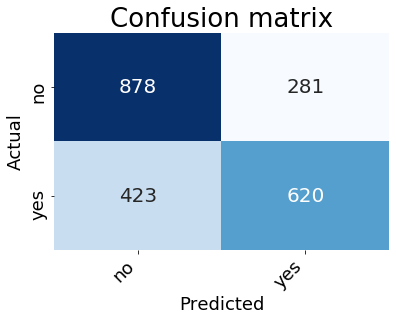

In [108]:
print_conf_matrix_and_report(lr_predictions)

Tuning regularization hyperparameter with cross-validation.

In [109]:
evaluator = BinaryClassificationEvaluator()
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0, 0.1, 0.3])
              .addGrid(lr.maxIter, [10, 15])
             .build())
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)

In [110]:
best_lr_model = cvModel.bestModel
cv_lr_predictions = best_lr_model.transform(test)
acc = accuracy_m(cv_lr_predictions)
best_accuracies[type(best_lr_model).__name__] = acc

Model accuracy: 67.620%


              precision    recall  f1-score   support

         0.0       0.67      0.76      0.71      1159
         1.0       0.69      0.58      0.63      1043

    accuracy                           0.68      2202
   macro avg       0.68      0.67      0.67      2202
weighted avg       0.68      0.68      0.67      2202



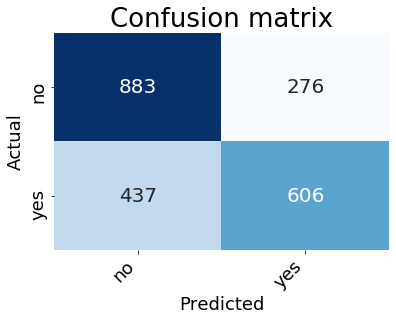

In [111]:
print_conf_matrix_and_report(cv_lr_predictions)

In [112]:
print('The best Logistic Regression CV regularization param: ' + str(cvModel.bestModel.getOrDefault('regParam')))

The best Logistic Regression CV regularization param: 0.0


## Decision Tree

In [113]:
dt = DecisionTreeClassifier(featuresCol = 'selected_features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
dt_predictions = dtModel.transform(test)

In [114]:
dt_predictions.select('selected_features', 'rawPrediction', 'probability', 'prediction', 'label').show(10)

+--------------------+---------------+--------------------+----------+-----+
|   selected_features|  rawPrediction|         probability|prediction|label|
+--------------------+---------------+--------------------+----------+-----+
|(29,[4,9,12,13,15...|   [68.0,783.0]|[0.07990599294947...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  0.0|
|(29,[4,9,13,15,17...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  1.0|
|(29,[4,9,10,13,15...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  1.0|
|(29,[4,9,10,13,15...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  1.0|
|(29,[4,9,11,13,16...| [1459.0,414.0]|[0.77896422851041...|       0.0|  0.0|
|(29,[4,9,12,13,15...|   [68.0,783.0]|[0.07990599294947...|       1.0|  1.0|
|(29,[4,9,12,13,15...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  1.0|
|(29,[4,9,10,13,15...|   [68.0,783.0]|[0.07990599294947...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  0.0|

In [115]:
accuracy_m(dt_predictions)

Model accuracy: 63.397%


0.633969118982743

              precision    recall  f1-score   support

         0.0       0.59      0.96      0.73      1159
         1.0       0.85      0.28      0.42      1043

    accuracy                           0.63      2202
   macro avg       0.72      0.62      0.58      2202
weighted avg       0.71      0.63      0.58      2202



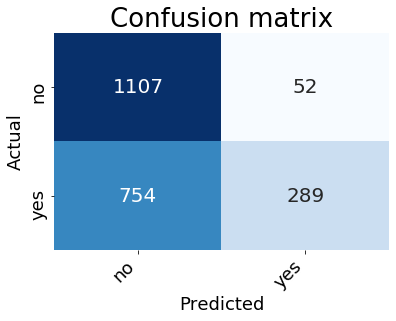

In [116]:
print_conf_matrix_and_report(dt_predictions)

In [120]:
evaluator = BinaryClassificationEvaluator()
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1,2,3,4,5])
             .addGrid(dt.maxBins, [2, 4, 8])
             .build())
cv = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)
dt_cvModel = cv.fit(train)

In [121]:
best_dt_model = dt_cvModel.bestModel
cv_dt_predictions = best_dt_model.transform(test)
acc = accuracy_m(cv_dt_predictions)
best_accuracies[type(best_dt_model).__name__] = acc

Model accuracy: 67.530%


              precision    recall  f1-score   support

         0.0       0.69      0.70      0.69      1159
         1.0       0.66      0.65      0.66      1043

    accuracy                           0.68      2202
   macro avg       0.67      0.67      0.67      2202
weighted avg       0.68      0.68      0.68      2202



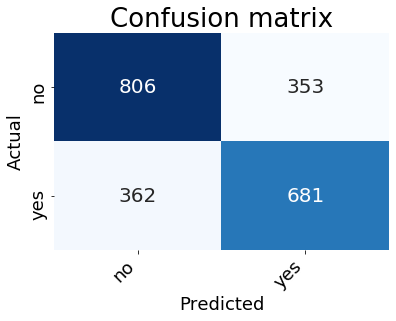

In [122]:
print_conf_matrix_and_report(cv_dt_predictions)

In [123]:
print('The best DecisionTree CV model max_depth param: ' + str(best_dt_model.getOrDefault('maxDepth'))\
       + ", maxBins: " + str(best_dt_model.getOrDefault('maxBins')))

The best DecisionTree CV model max_depth param: 5, maxBins: 2


## Random Forest

In [124]:
rf = RandomForestClassifier(featuresCol = 'selected_features', labelCol = 'label', maxDepth = 3, numTrees  = 20, )
rfModel = dt.fit(train)
rf_predictions = rfModel.transform(test)

In [125]:
rf_predictions.select('selected_features', 'rawPrediction', 'probability', 'prediction', 'label').show(10)

+--------------------+---------------+--------------------+----------+-----+
|   selected_features|  rawPrediction|         probability|prediction|label|
+--------------------+---------------+--------------------+----------+-----+
|(29,[4,9,12,13,15...|   [68.0,783.0]|[0.07990599294947...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  0.0|
|(29,[4,9,13,15,17...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  1.0|
|(29,[4,9,10,13,15...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  1.0|
|(29,[4,9,10,13,15...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  1.0|
|(29,[4,9,11,13,16...| [1459.0,414.0]|[0.77896422851041...|       0.0|  0.0|
|(29,[4,9,12,13,15...|   [68.0,783.0]|[0.07990599294947...|       1.0|  1.0|
|(29,[4,9,12,13,15...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  1.0|
|(29,[4,9,10,13,15...|   [68.0,783.0]|[0.07990599294947...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[3075.0,2718.0]|[0.53081305023303...|       0.0|  0.0|

In [126]:
accuracy_m(rf_predictions)

Model accuracy: 63.397%


0.633969118982743

              precision    recall  f1-score   support

         0.0       0.59      0.96      0.73      1159
         1.0       0.85      0.28      0.42      1043

    accuracy                           0.63      2202
   macro avg       0.72      0.62      0.58      2202
weighted avg       0.71      0.63      0.58      2202



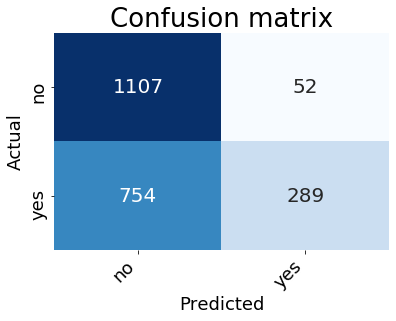

In [127]:
print_conf_matrix_and_report(rf_predictions)

In [128]:
evaluator = BinaryClassificationEvaluator()
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [3,4,5])
             .addGrid(rf.maxBins, [8, 16, 32])
             .addGrid(rf.numTrees , [10, 20, 30])
             .build())
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)
rf_cvModel = cv.fit(train)

In [129]:
best_rf_model = rf_cvModel.bestModel
cv_rf_predictions = best_rf_model.transform(test)
acc = accuracy_m(cv_rf_predictions)
best_accuracies[type(best_rf_model).__name__] = acc

Model accuracy: 68.847%


              precision    recall  f1-score   support

         0.0       0.67      0.81      0.73      1159
         1.0       0.73      0.55      0.63      1043

    accuracy                           0.69      2202
   macro avg       0.70      0.68      0.68      2202
weighted avg       0.70      0.69      0.68      2202



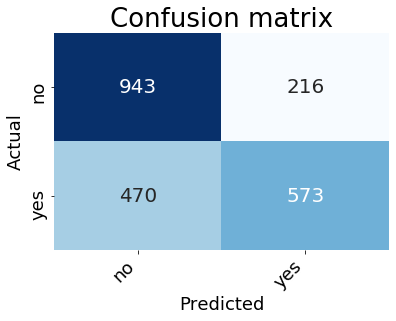

In [130]:
print_conf_matrix_and_report(cv_rf_predictions)

In [131]:
print('The best RandomForest CV model max_depth param: ' + str(best_rf_model.getOrDefault('maxDepth'))\
       + ", maxBins: " + str(best_rf_model.getOrDefault('maxBins'))
       + ", numTrees: " + str(best_rf_model.getOrDefault('numTrees'))
       + ", impurity: " + str(best_rf_model.getOrDefault('impurity')))

The best RandomForest CV model max_depth param: 5, maxBins: 32, numTrees: 30, impurity: gini


## Gradient-Boosted Tree Classifier

In [132]:
gbt = GBTClassifier(featuresCol = 'selected_features', labelCol = 'label',stepSize=0.1, maxDepth=5, maxBins=32, maxIter=20)
gbtModel = gbt.fit(train)
gbt_predictions = gbtModel.transform(test)

In [133]:
gbt_predictions.select('selected_features', 'rawPrediction', 'probability', 'prediction', 'label').show(10)

+--------------------+--------------------+--------------------+----------+-----+
|   selected_features|       rawPrediction|         probability|prediction|label|
+--------------------+--------------------+--------------------+----------+-----+
|(29,[4,9,12,13,15...|[-1.1286519213867...|[0.09472130974241...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[-0.5617170252148...|[0.24537485817950...|       1.0|  0.0|
|(29,[4,9,13,15,17...|[-0.5177683415947...|[0.26201211154596...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[-0.7961673960713...|[0.16905566156137...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[-0.7961673960713...|[0.16905566156137...|       1.0|  1.0|
|(29,[4,9,11,13,16...|[0.48157372755462...|[0.72375153531622...|       0.0|  0.0|
|(29,[4,9,12,13,15...|[-0.7382585492476...|[0.18595406746310...|       1.0|  1.0|
|(29,[4,9,12,13,15...|[-0.3795406326077...|[0.31884576670233...|       1.0|  1.0|
|(29,[4,9,10,13,15...|[-0.8590569835504...|[0.15211425613936...|       1.0|  1.0|
|(29,[4,9,10,13,

In [134]:
accuracy_m(gbt_predictions)

Model accuracy: 69.164%


0.6916439600363307

              precision    recall  f1-score   support

         0.0       0.68      0.79      0.73      1159
         1.0       0.72      0.58      0.64      1043

    accuracy                           0.69      2202
   macro avg       0.70      0.69      0.69      2202
weighted avg       0.70      0.69      0.69      2202



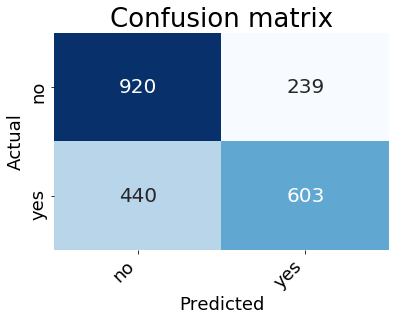

In [135]:
print_conf_matrix_and_report(gbt_predictions)

In [136]:
evaluator = BinaryClassificationEvaluator()
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.stepSize , [0.05, 0.1, 0.2])
             .addGrid(gbt.maxDepth, [5])
             .addGrid(gbt.maxBins, [32])
             .addGrid(gbt.maxIter , [30])
             .build())
cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)
gbt_cvModel = cv.fit(train)

In [137]:
best_gbt_model = gbt_cvModel.bestModel
cv_gbt_predictions = best_gbt_model.transform(test)
acc = accuracy_m(cv_gbt_predictions)
best_accuracies[type(best_gbt_model).__name__] = acc

Model accuracy: 69.119%


In [138]:
print('The best GBTClassifier CV model max_depth param: ' + str(best_gbt_model.getOrDefault('maxDepth'))\
       + ", maxBins: " + str(best_gbt_model.getOrDefault('maxBins'))
       + ", maxIter: " + str(best_gbt_model.getOrDefault('maxIter'))
       + ", stepSize: " + str(best_gbt_model.getOrDefault('stepSize')))

The best GBTClassifier CV model max_depth param: 5, maxBins: 32, maxIter: 30, stepSize: 0.1


## Summary

In [139]:
print_best_accuracies()

Best accuracies:
 - LogisticRegressionModel: 67.620%
 - DecisionTreeClassificationModel: 67.530%
 - RandomForestClassificationModel: 68.847%
 - GBTClassificationModel: 69.119%


## Sources
 - Data: https://www.kaggle.com/rouseguy/bankbalanced
 - https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/
 - https://www.guru99.com/pyspark-tutorial.html